In [35]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, recall_score
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time

In [2]:
# Step 1: Load CSV data
print("Step 1: Loading CSV data")
exams_df = pd.read_csv('exams.csv')
labels_df = pd.read_csv('samitrop_chagas_labels.csv')

print(f"Exams data: {len(exams_df)} rows")
print(f"Labels data: {len(labels_df)} rows")


Step 1: Loading CSV data
Exams data: 1631 rows
Labels data: 815 rows


In [3]:
# Display sample data
print("\nExams data sample:")
print(exams_df.head(3))
print("\nLabels data sample:")
print(labels_df.head(3))


Exams data sample:
   exam_id  age  is_male  normal_ecg  death     timey  nn_predicted_age
0   294669   67     True       False  False  2.116020         51.093110
1   291318   65     True       False  False  3.077345         76.923935
2   247007   67    False       False  False  2.378450         61.212074

Labels data sample:
   exam_id  chagas
0   247007    True
1   181629    True
2   406936    True


In [4]:
# Set all exams as negative by default
exams_df['chagas'] = 0

# Update the chagas labels for the 815 IDs in labels_df to be positive
exams_df.loc[exams_df['exam_id'].isin(labels_df['exam_id']), 'chagas'] = 1


merged_df = exams_df
print(f"\nTotal records: {len(merged_df)}")


Total records: 1631


In [5]:
# Check class balance
chagas_count = merged_df['chagas'].sum()
print(f"Chagas positive: {chagas_count} ({chagas_count/len(merged_df)*100:.2f}%)")
print(f"Chagas negative: {len(merged_df) - chagas_count} ({(1-chagas_count/len(merged_df))*100:.2f}%)")


Chagas positive: 815 (49.97%)
Chagas negative: 816 (50.03%)


In [6]:
# Step 2: Load ECG data from HDF5 file
print("\nStep 2: Loading ECG data from HDF5 file")

if not os.path.exists('exams.hdf5'):
    raise FileNotFoundError("The file 'exams.hdf5' was not found in the current directory.")

# Open HDF5 file
with h5py.File('exams.hdf5', 'r') as hdf:
    # Print the structure of the HDF5 file
    print("HDF5 file structure:")
    for key in hdf.keys():
        print(f"Key: {key}")
        if isinstance(hdf[key], h5py.Group):
            print(f"  Type: Group")
            for subkey in hdf[key].keys():
                print(f"  Subkey: {subkey}")
        else:
            print(f"  Type: Dataset")
            print(f"  Shape: {hdf[key].shape}")
    
    # Your HDF5 has a 'tracings' key
    if 'tracings' in hdf:
        print("\nAccessing 'tracings' dataset")
        tracings = hdf['tracings']
        print(f"Tracings shape: {tracings.shape}")
        
        # Check if there's an 'exam_id' dataset that maps indices to exam_ids
        if 'exam_id' in hdf:
            # If there's a mapping between indices and exam_ids
            exam_id_mapping = hdf['exam_id'][:]
            print(f"Found exam_id mapping with {len(exam_id_mapping)} entries")
        else:
            # If there's no explicit mapping, we'll need to determine how tracings map to exam_ids
            print("No explicit exam_id mapping found. Assuming sequential ordering.")
            # Here we're assuming that the order of tracings corresponds to the order of exam_ids in the CSV
            exam_id_mapping = merged_df['exam_id'].values
            if len(exam_id_mapping) != tracings.shape[0]:
                print(f"Warning: Number of tracings ({tracings.shape[0]}) doesn't match number of exam_ids ({len(exam_id_mapping)})")
                # Use the minimum number to avoid index errors
                min_length = min(len(exam_id_mapping), tracings.shape[0])
                exam_id_mapping = exam_id_mapping[:min_length]
                print(f"Using first {min_length} exam_ids for mapping")
        
        # Initialize lists to store ECG data and labels
        ecg_data = []
        labels = []
        original_ids = []
        
        # Load ECG data for each exam
        print("\nLoading ECG data...")
        for i in range(len(exam_id_mapping)):
            if i % 100 == 0:
                print(f"  Progress: {i}/{len(exam_id_mapping)} ECGs loaded")
            
            # Get the exam_id for this tracing
            exam_id = exam_id_mapping[i]
            
            # Get the label from our merged dataframe
            label_row = merged_df.loc[merged_df['exam_id'] == exam_id]
            if len(label_row) == 0:
                print(f"  Warning: No label found for ID {exam_id}. Skipping.")
                continue
            
            label = label_row['chagas'].values[0]
            
            try:
                # Get the ECG data
                ecg = tracings[i]
                
                # Check and fix shape if needed
                if len(ecg.shape) == 1:
                    # If it's one-dimensional, reshape it
                    print(f"  Single-dimension ECG found with shape {ecg.shape}. Reshaping...")
                    # Assume it's 12 leads concatenated
                    n_samples = ecg.shape[0] // 12
                    ecg = ecg.reshape(n_samples, 12)
                
                # Print shape info for the first ECG
                if i == 0:
                    print(f"  First ECG shape: {ecg.shape}")
                    # If shape is (12, time_points) instead of (time_points, 12), transpose it
                    if ecg.shape[1] != 12 and ecg.shape[0] == 12:
                        print("  Transposing ECG data to get (time_points, leads) format")
                        ecg = ecg.T
                        print(f"  Transposed shape: {ecg.shape}")
                
                # Add to lists
                ecg_data.append(ecg)
                labels.append(label)
                original_ids.append(exam_id)
            except Exception as e:
                print(f"  Error loading ECG for ID {exam_id}: {e}")
                continue
    else:
        raise ValueError("Expected 'tracings' dataset not found in HDF5 file")



Step 2: Loading ECG data from HDF5 file
HDF5 file structure:
Key: tracings
  Type: Dataset
  Shape: (1631, 4096, 12)

Accessing 'tracings' dataset
Tracings shape: (1631, 4096, 12)
No explicit exam_id mapping found. Assuming sequential ordering.

Loading ECG data...
  Progress: 0/1631 ECGs loaded
  First ECG shape: (4096, 12)
  Progress: 100/1631 ECGs loaded
  Progress: 200/1631 ECGs loaded
  Progress: 300/1631 ECGs loaded
  Progress: 400/1631 ECGs loaded
  Progress: 500/1631 ECGs loaded
  Progress: 600/1631 ECGs loaded
  Progress: 700/1631 ECGs loaded
  Progress: 800/1631 ECGs loaded
  Progress: 900/1631 ECGs loaded
  Progress: 1000/1631 ECGs loaded
  Progress: 1100/1631 ECGs loaded
  Progress: 1200/1631 ECGs loaded
  Progress: 1300/1631 ECGs loaded
  Progress: 1400/1631 ECGs loaded
  Progress: 1500/1631 ECGs loaded
  Progress: 1600/1631 ECGs loaded


In [7]:

# Check if we loaded any data
if len(ecg_data) == 0:
    raise ValueError("No ECG data was successfully loaded. Cannot proceed.")

print(f"Successfully loaded {len(ecg_data)} ECGs")

# Check if ECGs have consistent shapes
shapes = [ecg.shape for ecg in ecg_data]
unique_shapes = set(shapes)
if len(unique_shapes) > 1:
    print(f"Warning: Inconsistent ECG shapes detected. Found {len(unique_shapes)} different shapes.")
    
    # Find the most common shape
    most_common_shape = max(unique_shapes, key=shapes.count)
    print(f"Using most common shape: {most_common_shape}")
    
    # Filter to keep only ECGs with the most common shape
    filtered_data = []
    filtered_labels = []
    filtered_ids = []
    for i in range(len(ecg_data)):
        if ecg_data[i].shape == most_common_shape:
            filtered_data.append(ecg_data[i])
            filtered_labels.append(labels[i])
            filtered_ids.append(original_ids[i])
    
    ecg_data = filtered_data
    labels = filtered_labels
    original_ids = filtered_ids
    print(f"After filtering: {len(ecg_data)} ECGs with consistent shape")

# Create numpy arrays for model training
# Ensure all ECGs have the same length
if len(ecg_data) > 0:
    time_points = max(ecg.shape[0] for ecg in ecg_data)
    n_leads = ecg_data[0].shape[1]  # Typically 12 for standard ECG
    
    X = np.zeros((len(ecg_data), time_points, n_leads))
    for i, ecg in enumerate(ecg_data):
        # Pad or truncate to the same length
        if ecg.shape[0] < time_points:
            # Pad with zeros
            X[i, :ecg.shape[0], :] = ecg
        else:
            # Truncate
            X[i, :, :] = ecg[:time_points, :]
            
    y = np.array(labels)
    
    print(f"Final ECG data shape: {X.shape}")
    print(f"Labels shape: {y.shape}")

Successfully loaded 1631 ECGs
Final ECG data shape: (1631, 4096, 12)
Labels shape: (1631,)


In [8]:
# Step 3: Preprocess ECG data
print("\nStep 3: Preprocessing ECG data")

# Split data into training and testing sets
X_indices = np.arange(len(X))
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X, y, X_indices, test_size=0.2, random_state=42, stratify=y
)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

# Normalize each ECG to have zero mean and unit variance
for i in range(X_train.shape[0]):
    for lead in range(X_train.shape[2]):
        # Avoid division by zero
        std = np.std(X_train[i, :, lead])
        if std == 0:
            X_train[i, :, lead] = 0
        else:
            X_train[i, :, lead] = (X_train[i, :, lead] - np.mean(X_train[i, :, lead])) / std

for i in range(X_test.shape[0]):
    for lead in range(X_test.shape[2]):
        # Avoid division by zero
        std = np.std(X_test[i, :, lead])
        if std == 0:
            X_test[i, :, lead] = 0
        else:
            X_test[i, :, lead] = (X_test[i, :, lead] - np.mean(X_test[i, :, lead])) / std



Step 3: Preprocessing ECG data
Training set size: (1304, 4096, 12)
Testing set size: (327, 4096, 12)


In [9]:
# Step 4: Visualize sample ECGs
print("\nStep 4: Visualizing sample ECGs")

# Get indices of Chagas positive and negative samples
pos_indices = np.where(y == 1)[0]
neg_indices = np.where(y == 0)[0]

# Check if we have samples of both classes
if len(pos_indices) > 0 and len(neg_indices) > 0:
    # Number of samples to visualize
    n_samples = 2
    
    # Plot Chagas positive and negative samples
    plt.figure(figsize=(15, 10))
    
    # Plot Chagas positive samples
    for i in range(min(n_samples, len(pos_indices))):
        idx = pos_indices[i]
        plt.subplot(2, n_samples, i+1)
        
        # Plot all leads
        for lead in range(X.shape[2]):
            plt.plot(X[idx, :, lead], alpha=0.7, linewidth=0.5)
        
        plt.title(f"Chagas Positive (ID: {original_ids[idx]})")
        plt.ylim(-5, 5)
    
    # Plot Chagas negative samples
    for i in range(min(n_samples, len(neg_indices))):
        idx = neg_indices[i]
        plt.subplot(2, n_samples, i+n_samples+1)
        
        # Plot all leads
        for lead in range(X.shape[2]):
            plt.plot(X[idx, :, lead], alpha=0.7, linewidth=0.5)
        
        plt.title(f"Chagas Negative (ID: {original_ids[idx]})")
        plt.ylim(-5, 5)
    
    plt.tight_layout()
    plt.savefig('sample_ecgs.png')
    plt.close()
    print("Sample ECGs saved to 'sample_ecgs.png'")
else:
    print("Cannot visualize: missing examples from one or both classes")



Step 4: Visualizing sample ECGs
Sample ECGs saved to 'sample_ecgs.png'


In [10]:
# Step 5: PyTorch Dataset and DataLoader
print("\nStep 5: Creating PyTorch Dataset and DataLoader")

# Define a custom Dataset class
class ECGDataset(Dataset):
    def __init__(self, ecg_data, labels):
        self.ecg_data = torch.tensor(ecg_data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return len(self.ecg_data)
    
    def __getitem__(self, idx):
        ecg = self.ecg_data[idx]
        label = self.labels[idx]
        return ecg, label

# Create datasets
train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Created train_loader with {len(train_loader)} batches of size {batch_size}")
print(f"Created test_loader with {len(test_loader)} batches of size {batch_size}")



Step 5: Creating PyTorch Dataset and DataLoader
Created train_loader with 82 batches of size 16
Created test_loader with 21 batches of size 16


In [11]:
# Step 6: Define PyTorch model
print("\nStep 6: Building PyTorch CNN model")

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the CNN model
class ECGModel(nn.Module):
    def __init__(self, input_channels=12):
        super(ECGModel, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the size of flattened features after convolutions and pooling
        # For a time series of length L, after two pooling layers of kernel_size=2, we have L/4
        self.flattened_size = (time_points // 4) * 128
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # PyTorch Conv1d expects input shape (batch_size, channels, seq_length)
        # Our data is (batch_size, seq_length, channels), so we need to permute
        x = x.permute(0, 2, 1)
        
        # Convolutional blocks
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout1(self.relu3(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        
        return x

# Initialize model
model = ECGModel(input_channels=n_leads)
model = model.to(device)

# Print model summary
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")


Step 6: Building PyTorch CNN model
Using device: cpu
ECGModel(
  (conv1): Conv1d(12, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=64, bias=True)
  (relu3): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Total parameters: 8433729


In [12]:
# Step 7: Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [13]:
# Step 8: Train the model
print("\nStep 8: Training model")

# Tracking variables
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_loss = float('inf')
best_model_state = None
patience = 5
patience_counter = 0
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    
    # Training phase
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Print progress
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # Calculate epoch statistics
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            val_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    # Calculate validation statistics
    val_epoch_loss = val_loss / len(test_dataset)
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
    # Print epoch results
    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] - {epoch_time:.2f}s - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    
    # Check for early stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

# Load the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation loss: {best_val_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.close()
print("Training history saved to 'training_history.png'")



Step 8: Training model
Epoch [1/20], Batch [10/82], Loss: 0.7007
Epoch [1/20], Batch [20/82], Loss: 0.7069
Epoch [1/20], Batch [30/82], Loss: 0.6903
Epoch [1/20], Batch [40/82], Loss: 0.6891
Epoch [1/20], Batch [50/82], Loss: 0.6955
Epoch [1/20], Batch [60/82], Loss: 0.6906
Epoch [1/20], Batch [70/82], Loss: 0.6844
Epoch [1/20], Batch [80/82], Loss: 0.6863
Epoch [1/20] - 39.84s - Loss: 0.8762, Acc: 0.4923, Val Loss: 0.6935, Val Acc: 0.4924
Epoch [2/20], Batch [10/82], Loss: 0.6904
Epoch [2/20], Batch [20/82], Loss: 0.6945
Epoch [2/20], Batch [30/82], Loss: 0.6740
Epoch [2/20], Batch [40/82], Loss: 0.6965
Epoch [2/20], Batch [50/82], Loss: 0.6907
Epoch [2/20], Batch [60/82], Loss: 0.6967
Epoch [2/20], Batch [70/82], Loss: 0.6776
Epoch [2/20], Batch [80/82], Loss: 0.6864
Epoch [2/20] - 39.12s - Loss: 0.6922, Acc: 0.5130, Val Loss: 0.6912, Val Acc: 0.5229
Epoch [3/20], Batch [10/82], Loss: 0.6654
Epoch [3/20], Batch [20/82], Loss: 0.6807
Epoch [3/20], Batch [30/82], Loss: 0.6975
Epoch [3

In [14]:
# Step 9: Evaluate model
print("\nStep 9: Evaluating model")

# Set model to evaluation mode
model.eval()

# Initialize arrays to store predictions and true labels
all_preds = []
all_preds_prob = []
all_labels = []

# Test the model
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Convert to CPU and numpy for evaluation
        preds_prob = outputs.cpu().numpy()
        preds = (outputs > 0.5).float().cpu().numpy()
        labels = labels.cpu().numpy()
        
        # Append batch predictions to lists
        all_preds.extend(preds)
        all_preds_prob.extend(preds_prob)
        all_labels.extend(labels)

# Convert lists to numpy arrays
all_preds = np.array(all_preds).flatten()
all_preds_prob = np.array(all_preds_prob).flatten()
all_labels = np.array(all_labels).flatten()

# Calculate metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(conf_matrix)

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(all_labels, all_preds_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.close()
print("ROC curve saved to 'roc_curve.png'")


Step 9: Evaluating model

Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.56      0.56       164
         1.0       0.55      0.54      0.54       163

    accuracy                           0.55       327
   macro avg       0.55      0.55      0.55       327
weighted avg       0.55      0.55      0.55       327


Confusion Matrix:
[[92 72]
 [75 88]]
ROC curve saved to 'roc_curve.png'


In [15]:
# Step 10: Save model and results
print("\nStep 10: Saving results")

# Save PyTorch model
torch.save(model.state_dict(), 'chagas_detection_model.pth')
print("Model saved to 'chagas_detection_model.pth'")

# Map back to original exam IDs
original_test_ids = [original_ids[i] for i in test_indices]

# Create DataFrame with predictions for future use
predictions_df = pd.DataFrame({
    'exam_id': original_test_ids,
    'true_chagas': all_labels,
    'predicted_prob': all_preds_prob,
    'predicted_chagas': all_preds
})

# Save predictions to CSV
predictions_df.to_csv('chagas_predictions.csv', index=False)
print("Predictions saved to 'chagas_predictions.csv'")

print("\nScript completed successfully!")


Step 10: Saving results
Model saved to 'chagas_detection_model.pth'
Predictions saved to 'chagas_predictions.csv'

Script completed successfully!


In [17]:
# Define the Row-wise CNN model (analyzes each lead over time)
class RowWiseECGModel(nn.Module):
    def __init__(self, input_channels=12):
        super(RowWiseECGModel, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the size of flattened features after convolutions and pooling
        # For a time series of length L, after two pooling layers of kernel_size=2, we have L/4
        self.flattened_size = (time_points // 4) * 128
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # PyTorch Conv1d expects input shape (batch_size, channels, seq_length)
        # Our data is (batch_size, seq_length, channels), so we need to permute
        x = x.permute(0, 2, 1)
        
        # Convolutional blocks
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout1(self.relu3(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        
        return x


In [18]:
# Define the Column-wise CNN model (analyzes across leads at each time point)
class ColumnWiseECGModel(nn.Module):
    def __init__(self, input_channels=time_points):
        super(ColumnWiseECGModel, self).__init__()
        
        # First convolutional block - now operating across leads at each time point
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the size of flattened features after convolutions and pooling
        # For leads dimension, which is typically 12, after pooling it becomes 12/4 = 3 (or less if leads < 12)
        self.flattened_size = (n_leads // 4 if n_leads >= 4 else 1) * 128
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # No need to permute - we'll view the data differently
        # We want (batch_size, time_points, leads) -> (batch_size, time_points, leads)
        # This already has time_points as "channels" and leads as the "sequence"
        
        # Reshape to make time_points the channels dimension
        x = x.permute(0, 1, 2)  # Now it's (batch_size, time_points, leads)
        
        # Convolutional blocks
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout1(self.relu3(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))
        
        return x

In [19]:

# Initialize both models
row_model = RowWiseECGModel(input_channels=n_leads)
row_model = row_model.to(device)

col_model = ColumnWiseECGModel(input_channels=time_points)
col_model = col_model.to(device)

# Print model summaries
print("Row-wise Model (analyzing each lead over time):")
print(row_model)
row_params = sum(p.numel() for p in row_model.parameters())
print(f"Total parameters: {row_params}")

print("\nColumn-wise Model (analyzing across leads at each time point):")
print(col_model)
col_params = sum(p.numel() for p in col_model.parameters())
print(f"Total parameters: {col_params}")

Row-wise Model (analyzing each lead over time):
RowWiseECGModel(
  (conv1): Conv1d(12, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=64, bias=True)
  (relu3): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Total parameters: 8433729

Column-wise Model (analyzing across leads at each time point):
ColumnWiseECGModel(
  (conv1): Conv1d(4096, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu2): ReLU

In [20]:
# Choose which model to use for training
model_type = "row"  # Options: "row" or "col"

if model_type == "row":
    model = row_model
    print("\nUsing Row-wise Model for training")
else:
    model = col_model
    print("\nUsing Column-wise Model for training")


Using Row-wise Model for training


In [21]:
# Define loss function
criterion = nn.BCELoss()

In [22]:
# Step 8: Train both models
print("\nStep 8: Training both models")

def train_model(model_name, model, train_loader, test_loader, device, criterion, learning_rate=0.001, num_epochs=20, patience=5):
    print(f"\n----- Training {model_name} Model -----")
    
    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Tracking variables
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()
        
        # Training phase
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Print progress
            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
        
        # Calculate epoch statistics
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        # Calculate validation statistics
        val_epoch_loss = val_loss / len(test_dataset)
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)
        
        # Print epoch results
        epoch_time = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] - {epoch_time:.2f}s - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
        
        # Check for early stopping
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after epoch {epoch+1}")
                break
    
    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Loaded best model with validation loss: {best_val_loss:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Validation')
    plt.title(f'{model_name} Model - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Validation')
    plt.title(f'{model_name} Model - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_training_history.png')
    plt.close()
    print(f"{model_name} Model training history saved to '{model_name.lower()}_training_history.png'")
    
    return model, best_val_loss


Step 8: Training both models


In [23]:
# Train both models
row_model_trained, row_best_loss = train_model("Row-wise", row_model, train_loader, test_loader, device, criterion, learning_rate=0.001, num_epochs=20)
col_model_trained, col_best_loss = train_model("Column-wise", col_model, train_loader, test_loader, device, criterion, learning_rate=0.001, num_epochs=20)

# Compare model performances
print("\nModel Performance Comparison:")
print(f"Row-wise Model Best Validation Loss: {row_best_loss:.4f}")
print(f"Column-wise Model Best Validation Loss: {col_best_loss:.4f}")



----- Training Row-wise Model -----
Epoch [1/20], Batch [10/82], Loss: 0.6815
Epoch [1/20], Batch [20/82], Loss: 0.6917
Epoch [1/20], Batch [30/82], Loss: 0.6690
Epoch [1/20], Batch [40/82], Loss: 0.7064
Epoch [1/20], Batch [50/82], Loss: 0.6839
Epoch [1/20], Batch [60/82], Loss: 0.6850
Epoch [1/20], Batch [70/82], Loss: 0.6941
Epoch [1/20], Batch [80/82], Loss: 0.7069
Epoch [1/20] - 26.30s - Loss: 0.7961, Acc: 0.4885, Val Loss: 0.6935, Val Acc: 0.5015
Epoch [2/20], Batch [10/82], Loss: 0.6959
Epoch [2/20], Batch [20/82], Loss: 0.6922
Epoch [2/20], Batch [30/82], Loss: 0.6828
Epoch [2/20], Batch [40/82], Loss: 0.6890
Epoch [2/20], Batch [50/82], Loss: 0.6957
Epoch [2/20], Batch [60/82], Loss: 0.6983
Epoch [2/20], Batch [70/82], Loss: 0.6912
Epoch [2/20], Batch [80/82], Loss: 0.6965
Epoch [2/20] - 26.76s - Loss: 0.6929, Acc: 0.5038, Val Loss: 0.6925, Val Acc: 0.5199
Epoch [3/20], Batch [10/82], Loss: 0.7064
Epoch [3/20], Batch [20/82], Loss: 0.6000
Epoch [3/20], Batch [30/82], Loss: 0.

In [24]:

if row_best_loss < col_best_loss:
    better_model = row_model_trained
    better_model_name = "Row-wise"
    print("Row-wise Model performed better and will be used for evaluation")
else:
    better_model = col_model_trained
    better_model_name = "Column-wise"
    print("Column-wise Model performed better and will be used for evaluation")

# Set the best model for further evaluation
model = better_model


Column-wise Model performed better and will be used for evaluation


In [25]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.close()
print("Training history saved to 'training_history.png'")


Training history saved to 'training_history.png'


In [26]:
# Step 9: Evaluate both models
print("\nStep 9: Evaluating both models")

def evaluate_model(model_name, model, test_loader, device):
    print(f"\n----- Evaluating {model_name} Model -----")
    
    # Set model to evaluation mode
    model.eval()
    
    # Initialize arrays to store predictions and true labels
    all_preds = []
    all_preds_prob = []
    all_labels = []
    
    # Test the model
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Convert to CPU and numpy for evaluation
            preds_prob = outputs.cpu().numpy()
            preds = (outputs > 0.5).float().cpu().numpy()
            labels = labels.cpu().numpy()
            
            # Append batch predictions to lists
            all_preds.extend(preds)
            all_preds_prob.extend(preds_prob)
            all_labels.extend(labels)
    
    # Convert lists to numpy arrays
    all_preds = np.array(all_preds).flatten()
    all_preds_prob = np.array(all_preds_prob).flatten()
    all_labels = np.array(all_labels).flatten()
    
    # Calculate metrics
    print(f"\n{model_name} Model Classification Report:")
    report = classification_report(all_labels, all_preds)
    print(report)
    
    # Confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    print(f"\n{model_name} Model Confusion Matrix:")
    print(conf_matrix)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_preds_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} Model - Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig(f'{model_name.lower()}_roc_curve.png')
    plt.close()
    print(f"ROC curve saved to '{model_name.lower()}_roc_curve.png'")
    
    return all_preds, all_preds_prob, all_labels, roc_auc



Step 9: Evaluating both models


In [27]:

# Evaluate both models
row_preds, row_preds_prob, row_labels, row_auc = evaluate_model("Row-wise", row_model_trained, test_loader, device)
col_preds, col_preds_prob, col_labels, col_auc = evaluate_model("Column-wise", col_model_trained, test_loader, device)

# Compare model ROC AUCs
print("\nModel ROC AUC Comparison:")
print(f"Row-wise Model AUC: {row_auc:.4f}")
print(f"Column-wise Model AUC: {col_auc:.4f}")

if row_auc > col_auc:
    print("Row-wise Model has better AUC")
    final_model_name = "Row-wise"
    final_preds = row_preds
    final_preds_prob = row_preds_prob
    final_labels = row_labels
else:
    print("Column-wise Model has better AUC")
    final_model_name = "Column-wise"
    final_preds = col_preds
    final_preds_prob = col_preds_prob
    final_labels = col_labels



----- Evaluating Row-wise Model -----

Row-wise Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.47      0.50       164
         1.0       0.52      0.58      0.55       163

    accuracy                           0.53       327
   macro avg       0.53      0.53      0.52       327
weighted avg       0.53      0.53      0.52       327


Row-wise Model Confusion Matrix:
[[77 87]
 [68 95]]
ROC curve saved to 'row-wise_roc_curve.png'

----- Evaluating Column-wise Model -----

Column-wise Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.52      0.52       164
         1.0       0.51      0.51      0.51       163

    accuracy                           0.51       327
   macro avg       0.51      0.51      0.51       327
weighted avg       0.51      0.51      0.51       327


Column-wise Model Confusion Matrix:
[[85 79]
 [80 83]]
ROC curve saved to 'column-wise

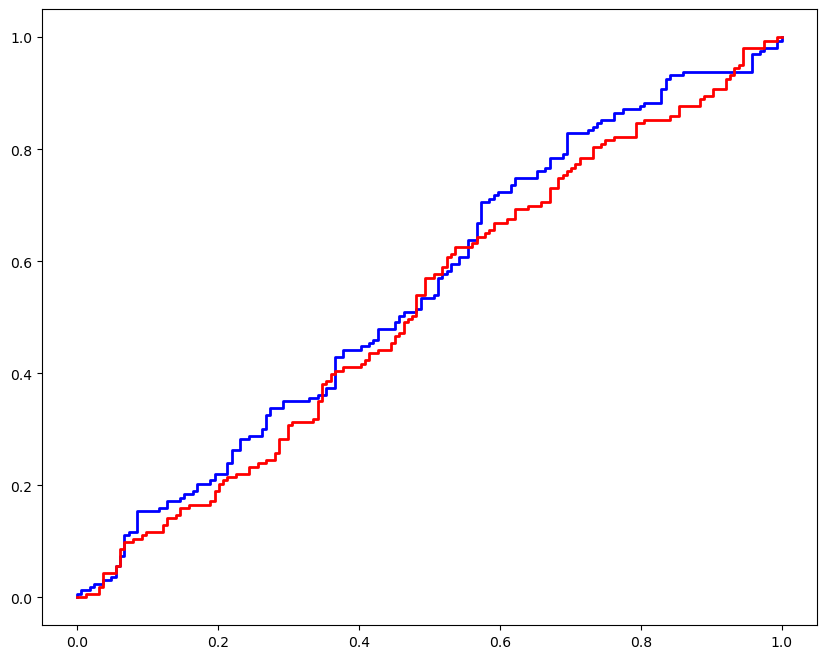

In [28]:

# Create a combined ROC curve plot
plt.figure(figsize=(10, 8))
# Row-wise model ROC
fpr_row, tpr_row, _ = roc_curve(row_labels, row_preds_prob)
plt.plot(fpr_row, tpr_row, color='blue', lw=2, label=f'Row-wise (AUC = {row_auc:.3f})')

# Column-wise model ROC
fpr_col, tpr_col, _ = roc_curve(col_labels, col_preds_prob)
plt.plot(fpr_col, tpr_col, color='red', lw=2, label=f'Column-wise (AUC = {col_auc:.3f})')


In [29]:
# Diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Comparison - Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('combined_roc_curve.png')
plt.close()
print("Combined ROC curve saved to 'combined_roc_curve.png'")


Combined ROC curve saved to 'combined_roc_curve.png'


C:\Users\rjhha\AppData\Local\Temp\ipykernel_14512\2405286142.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


In [30]:

# Step 10: Save models and results
print("\nStep 10: Saving results")

# Save both PyTorch models
torch.save(row_model_trained.state_dict(), 'chagas_row_model.pth')
print("Row-wise model saved to 'chagas_row_model.pth'")

torch.save(col_model_trained.state_dict(), 'chagas_col_model.pth')
print("Column-wise model saved to 'chagas_col_model.pth'")

# Map back to original exam IDs
original_test_ids = [original_ids[i] for i in test_indices]

# Create DataFrame with predictions from both models
predictions_df = pd.DataFrame({
    'exam_id': original_test_ids,
    'true_chagas': final_labels,
    'row_predicted_prob': row_preds_prob,
    'row_predicted_chagas': row_preds,
    'col_predicted_prob': col_preds_prob,
    'col_predicted_chagas': col_preds
})

# Add ensemble prediction (average of both models)
predictions_df['ensemble_prob'] = (predictions_df['row_predicted_prob'] + predictions_df['col_predicted_prob']) / 2
predictions_df['ensemble_chagas'] = (predictions_df['ensemble_prob'] > 0.5).astype(int)

# Calculate ensemble metrics
print("\nEnsemble Model Classification Report:")
print(classification_report(predictions_df['true_chagas'], predictions_df['ensemble_chagas']))



Step 10: Saving results
Row-wise model saved to 'chagas_row_model.pth'
Column-wise model saved to 'chagas_col_model.pth'

Ensemble Model Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.46      0.50       164
         1.0       0.53      0.61      0.57       163

    accuracy                           0.54       327
   macro avg       0.54      0.54      0.53       327
weighted avg       0.54      0.54      0.53       327



In [31]:
# Calculate ensemble ROC AUC
fpr_ensemble, tpr_ensemble, _ = roc_curve(predictions_df['true_chagas'], predictions_df['ensemble_prob'])
ensemble_auc = auc(fpr_ensemble, tpr_ensemble)
print(f"Ensemble Model AUC: {ensemble_auc:.4f}")

# Add ensemble to the ROC curve comparison
plt.figure(figsize=(10, 8))
# Row-wise model ROC
plt.plot(fpr_row, tpr_row, color='blue', lw=2, label=f'Row-wise (AUC = {row_auc:.3f})')
# Column-wise model ROC
plt.plot(fpr_col, tpr_col, color='red', lw=2, label=f'Column-wise (AUC = {col_auc:.3f})')
# Ensemble model ROC
plt.plot(fpr_ensemble, tpr_ensemble, color='green', lw=2, label=f'Ensemble (AUC = {ensemble_auc:.3f})')
# Diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Comparison - Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('ensemble_roc_curve.png')
plt.close()
print("Ensemble ROC curve saved to 'ensemble_roc_curve.png'")


Ensemble Model AUC: 0.5456
Ensemble ROC curve saved to 'ensemble_roc_curve.png'


In [32]:
# Save predictions to CSV
predictions_df.to_csv('chagas_predictions.csv', index=False)
print("Predictions saved to 'chagas_predictions.csv'")


Predictions saved to 'chagas_predictions.csv'


In [36]:
# Step 11: Compare model characteristics
print("\nStep 11: Model Characteristics Comparison")

# Create a comparison summary
comparison_df = pd.DataFrame({
    'Model': ['Row-wise', 'Column-wise', 'Ensemble'],
    'AUC': [row_auc, col_auc, ensemble_auc],
    'Accuracy': [
        (row_preds == final_labels).mean(), 
        (col_preds == final_labels).mean(), 
        (predictions_df['ensemble_chagas'] == predictions_df['true_chagas']).mean()
    ],
    'Sensitivity': [
        recall_score(final_labels, row_preds, pos_label=1),
        recall_score(final_labels, col_preds, pos_label=1),
        recall_score(predictions_df['true_chagas'], predictions_df['ensemble_chagas'], pos_label=1)
    ],
    'Specificity': [
        recall_score(final_labels, row_preds, pos_label=0),
        recall_score(final_labels, col_preds, pos_label=0),
        recall_score(predictions_df['true_chagas'], predictions_df['ensemble_chagas'], pos_label=0)
    ],
    'Prediction Approach': [
        'Analyzes each lead over time', 
        'Analyzes across leads at each time point', 
        'Average of Row and Column predictions'
    ]
})

# Print comparison table
print("\nModel Comparison Summary:")
print(comparison_df.to_string(index=False))

# Save comparison to CSV
comparison_df.to_csv('model_comparison.csv', index=False)
print("Model comparison saved to 'model_comparison.csv'")

print("\nScript completed successfully!")
print("\n----------------------------------------------")
print("Key findings:")
print(f"1. Row-wise model (lead-based analysis) achieved AUC of {row_auc:.4f}")
print(f"2. Column-wise model (time-point analysis) achieved AUC of {col_auc:.4f}")
print(f"3. Ensemble model (combined approach) achieved AUC of {ensemble_auc:.4f}")
print(f"4. Best performing single approach: {'Row-wise' if row_auc > col_auc else 'Column-wise'}")
print("5. All models were saved and can be used for future predictions")
print("----------------------------------------------")


Step 11: Model Characteristics Comparison

Model Comparison Summary:
      Model      AUC  Accuracy  Sensitivity  Specificity                      Prediction Approach
   Row-wise 0.551736  0.525994     0.582822     0.469512             Analyzes each lead over time
Column-wise 0.523156  0.513761     0.509202     0.518293 Analyzes across leads at each time point
   Ensemble 0.545563  0.535168     0.613497     0.457317    Average of Row and Column predictions
Model comparison saved to 'model_comparison.csv'

Script completed successfully!

----------------------------------------------
Key findings:
1. Row-wise model (lead-based analysis) achieved AUC of 0.5517
2. Column-wise model (time-point analysis) achieved AUC of 0.5232
3. Ensemble model (combined approach) achieved AUC of 0.5456
4. Best performing single approach: Row-wise
5. All models were saved and can be used for future predictions
----------------------------------------------
